CS 3630 Project 5: PoseSLAM with ICP
--------------------------------------
---

## Introduction
You will implement the ICP algorithm and use it with GTSAM to perform simultaneous localization & mapping (SLAM) on LIDAR scans from a self-driving car dataset. 

---

## Logistics
1. Date range: 11/08/2022 15:30 Tuesday - 11/22/2022 23:59 Tuesday.
2. Late due date: 11/25/2022 23:59 Friday.
3. Submisson should be made to Gradescope. Please carefully read the submission guidelines.

# Submission Details

Deliverables:

 1. project5.ipynb - exported from Google Colab and uploaded to Gradescope
 2. Answers to the reflection report - fill in the answers in Gradescope assignment "Project 5 Report".
Here is the [link](https://docs.google.com/presentation/d/13LnI7Od6iZD2nVEiqIwmihEpEUEOOeWD/edit?usp=share_link&ouid=108083578190322046971&rtpof=true&sd=true) to the report.

This is an individual assignment, everyone should submit their own files.

## Tips
1. Start early! There are some computationally intensive parts in this project so make sure you have ample time to run everything.
2. Make a copy of the notebook on Colab before running. (File > Save a copy in drive)

# Grading Rubric

 * Task 1 - Mapping (given poses): 15 points
 * Task 2 - ICP Inner Components: 5 points
 * Task 3 - Complete ICP Implementation: 15 points
 * Task 4 - Pose Graph Optimization: 15 points
 * Reflection: 50 points

# Extra Credit

 * Pose graph optimization with skip connections: 2 points

## **Collaboration Policy**
All projects in this course this semester are individual projects, which means ***no collaboration is allowed***.
However, you can discuss the projects and the reflection questions at a high level with your classmates or
the TAs. You can also ask questions on Piazza or go to office hours for help. All the code and all the
answers to the reflection questions must be your own.

Setup
-------

In this section, we'll install pip packages, define helper functions, and download the dataset.

In [ ]:
!pip install -q gtbook tqdm
!pip install  -q --upgrade --no-cache-dir gdown &> /dev/null
!gdown 11YTw2nf4s2rkv7wr37TLE5TBJEb0oCtZ
!unzip -qo project5_assets.zip

Next, load in the datset. This cell finds filenames for all of the point cloud files (.ply) in the dataset.

In [ ]:
%load_ext autoreload

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

import gtsam
from gtbook import driving
import gtsam.utils.plot as gtsam_plot

%autoreload 2
from project5_assets import helpers

LIDAR_FPATH = "project5_assets/lidar/"

scans_fnames = []
for file in sorted(os.listdir(LIDAR_FPATH)):
    scans_fnames.append(os.path.join(LIDAR_FPATH, file))

# Visualization

In this section, we'll become aquainted with the dataset.

This dataset is composed of 180 LIDAR scans (.ply files) captured by Argo AI, a self-driving car company based in Pittsburgh, PA ([which recently shut down :(](https://techcrunch.com/2022/10/26/ford-vw-backed-argo-ai-is-shutting-down/) ). These scans were captured over 18 seconds by one of their cars in Miami, which was equipped with a LIDAR sensor similar to this [one](https://velodynelidar.com/products/ultra-puck/). This 30 second video clip from the car's front camera gives a good intuition of what happens: https://youtu.be/FUDRK_0iEKA. The first 12 seconds, where the car is stationary, are not part of our dataset.

It's night-time and the car starts at an offset T-intersection. It waits for a car, three bicyclists, and another car to pass (12 seconds that are not part of our dataset). Then it makes a left turn onto NW 2nd Ave and traveling down the street (18 seconds that is our dataset).

In this cell, we read in the first LIDAR scan and visualizes it at full resolution (~88,000 points). Use the plot menu to zoom, pan, and rotate around the scene. Then, change the index on `scans_fnames` to see some of the later frames.

In [ ]:
cloud = driving.read_lidar_points(scans_fnames[0])
driving.visualize_cloud(cloud, show_grid_lines=True)

This cell reads in the first 20 LIDAR scans and visualizes them (as an animation) at a reduced resolution. Due to browser limitations, any additional frames after the first 5 must be rendered at reduced resolutions. Play around with the number of frames loaded by modifying the index on `scans_fnames`.

In [ ]:
# the more frames visualized, the lower the resolution of each cloud
clouds_subset = helpers.read_ply(*scans_fnames[:20], as_animation=True)

driving.visualize_clouds_animation(clouds_subset, show_grid_lines=True)

In [ ]:
# visualizing the entire sequence at a low resolution
clouds_all = helpers.read_ply(*scans_fnames, as_animation=True)

driving.visualize_clouds_animation(clouds_all)

# Task 1: Mapping (given poses)

After obtaining and viewing these LIDAR point cloud visualizations from the Argo AI datset, we are now *almost* able to to produce a corresponding map.

We say *almost* because we would like to create a map in the world frame, but the clouds are collected in the body frame of the robot. Therefore, we will need to transform all of the clouds from its respective pose to the world frame.

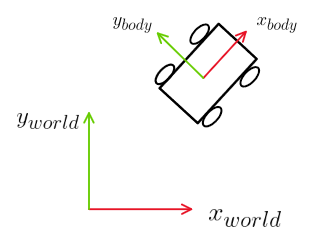

You'll do this by writing a `transform_cloud` method to specify the pose of each cloud with respect to the world frame (**in our case, the world frame is located at the initial pose of the self-driving car**). Visualizing all of these transformed clouds will then yield the complete map.

Let's take a moment to talk about the shape of these clouds. 
- Each cloud is a numpy array of shape (3, n), where n is the number of points in the cloud. 
- The first dimension is 3 because each point has an x, y, and z coordinate. The second dimension is n, because there are n points.
- Therefore, `cloud[ 0 ]` is be an array of length n that contains the x component of each point in the cloud. 
- Similarly, `cloud[ :, i]` would be an array of length 3, giving you the (x ,y ,z) coordinates of the $i^{th}$ point in the cloud.

#####**TODO 1:** Naive Transform [5 pts]

You will start by writing the naive implementation to transform the cloud. 
Here is what you need to do: 
- Using a for loop, iterate over each point in the point cloud.
- Transform each individual point from the body frame to the world frame.

Hints: 
- Use the `help()` function. Run the cell below to view the documentation of the `transformFrom` method to transform each point in the point cloud. You can view the documentation for any GTSAM function/class using this function. 
- Keep in mind the naming convention "transform from" denotes the transform **wTb**, transforming from a body frame **b** to the world frame **w**. 
- Note that that in Python, `gtsam.Point3` is synonymous with `numpy.ndarray[numpy.float64[3, 1]]`.

In [ ]:
help(gtsam.Pose3.transformFrom)

In [ ]:
def transform_cloud_naive(pose, clouda):
    """Transforms each point in a cloud
    given a gtsam.Pose3 transform.

    Args:
        pose (gtsam.Pose3): the transform used on each point in the cloud. 
        clouda (a numpy array of shape (3, n)): the cloud that we want to transform

    Returns:
        a numpy array of shape (3, n), where each 3D point is transformed by the pose
    """
    # TODO 1
    ############################################################################
    #                             START OF YOUR CODE                           #
    ############################################################################
    # Using a for loop, iterate over each point in the point cloud.
    # Transform each individual point from the body frame to the world frame.
    
    #Therefore, cloud[ 0 ] is be an array of length n that contains the x component of each point in the cloud.
    #Similarly, cloud[ :, i] would be an array of length 3, giving you the (x ,y ,z) coordinates of the  ith  point in the cloud.
    trans = []
    for i in range(len(clouda[0])):
      # print("x,y,z:", (clouda[:,i]))
      xyz = clouda[:,i]
      trans.append(pose.transformFrom(clouda[:,i]))
      # print(pose.transformFrom(clouda[:,i]))
    # print("transformed:\n",np.transpose(trans))
    trans = np.transpose(trans)
    
    transformed = pose.transformFrom(clouda) #pose.transformFrom(트렌스폼할대상)
    # print("pose:", pose, " clouda:",clouda )
    # print("뭐여무야:", wTb)
    # print("로테이토", wTb.rotation())
    # print("투렌스레", wTb.translation())
    # # print("clouda len", len(clouda))
    # # pose 의 x y z  = 6 8 5 
    # for i in range(len(clouda)):
    #   print("쿠라우다상",clouda[i])
    # print('쿠쿠',trans)
    return trans
    ############################################################################
    #                              END OF YOUR CODE                            #
    ############################################################################

Below, we've provided very basic unit tests for the `transform_cloud` method, which could help you debug your code!

In [ ]:
import unittest

class TestTransform(unittest.TestCase):

  def setUp(self):
      self.Rotation = gtsam.Rot3( np.array([[0.57367956, 0.4419256,  0.87448758],
                                            [0.94397185, 0.06276365, 0.60304828],
                                            [0.92277076, 0.43834417, 0.20227668]] ))
      self.Translation = gtsam.Point3(6,8,5)
      self.Transformation = gtsam.Pose3(self.Rotation, self.Translation)
      self.body_frame_points = np.array([[4.0, 4.0, 7.0, 9.0, 6.0],
                                          [8.0, 3.0, 6.0, 0.0, 8.0],
                                          [7.0, 8.0, 5.0, 7.0, 7.0]])
      self.transformed_points = np.array( [ [17.9515361,  16.61639568, 17.03974842, 17.2845291,  19.09889522],
                                            [16.49933456, 16.78856459, 17.99962625, 20.71708461, 18.38727826],
                                            [13.61377316, 11.62432899, 15.10084374, 14.7208736,  15.45931468]])
  
  def test_transform_naive(self):
    actual = transform_cloud_naive(self.Transformation, self.body_frame_points)
    return self.assertTrue(np.allclose(actual, self.transformed_points), "Check your Naive Implementation!")

  def test_transform_numpy(self):
    actual = transform_cloud_numpy(self.Transformation, self.body_frame_points)
    return self.assertTrue(np.allclose(actual, self.transformed_points), "Check your Numpy Implementation!")

In [ ]:
suite = unittest.TestSuite()
suite.addTest(TestTransform('test_transform_naive'))
unittest.TextTestRunner().run(suite)

This method is intuitive to understand and easy to implement, but unfortunately the performance is subpar. We'll be running this method for ~100 point clouds each with tens of thousand points, so we need this transform to be performed as efficiently as possible.

Instead of iterating through the point cloud and manually applying the `gtsam.Pose3` transform on each point in the cloud, we can instead convert the points into homogeneous points and then apply a homogeneous transformation to all of the points at once. 

#####**TODO 2:** Numpy Transform [5 pts]

This time around, we will transform the point cloud using numpy without any for loops. Here is what you need to do:
1. Convert the points of the point cloud into homogenous coordinates. Each point (x, y, z) will become (x, y, z, 1).
2. Obtain the homogenous transformation matrix from the given `gtsam.Pose3`. (Remember that the matrix dimensions will be 4x4)
3. Apply the transformation to the entire point cloud.
4. Convert the points back to their original dimensions.

Hint: 
- Type `help(gtsam.Pose3)` in a new cell to see what function can be used to obtain the rigid transform matrix.

In [ ]:
def transform_cloud_numpy(pose, clouda):
    """Transforms each point in a cloud
    given a gtsam.Pose3 transform.

    Args:
        pose (gtsam.Pose3): the transform used on each point in the cloud. 
        clouda (a numpy array of shape (3, n)): the cloud that we want to transform

    Returns:
        a numpy array of shape (3, n), where each 3D point is transformed by the pose
    """
    # TODO 2
    ############################################################################
    #                             START OF YOUR CODE                           #
    ############################################################################
    #  transform the point cloud using numpy without any for loops
    # Convert the points of the point cloud into homogenous coordinates. Each point (x, y, z) will become (x, y, z, 1).
    # Obtain the homogenous transformation matrix from the given gtsam.Pose3. (Remember that the matrix dimensions will be 4x4)
    # Apply the transformation to the entire point cloud.
    # Convert the points back to their original dimensions.
    # ones = np.ones((len(clouda[0]),1),dtype=int)
    # transpose = np.transpose(clouda)
    # print("트렌스젠더\n", transpose, "뭐\n", ones)
    # homo = np.append(transpose, ones, axis=1)
    p4 = pose.matrix()
    # print("p4:", p4)
    # hf = p4.transformFrom(homo)
    # print("호모\n:", homo)
    # print("hf:", hf)
    ones = np.ones(len(clouda[0]))
    hm = np.vstack([clouda, ones])
    # print("키키",hm)
    # print("컥컥",np.dot(p4,hm))    
    # print(len(clouda), len(clouda[0]))
    rowlen = len(clouda)
    collen = len(clouda[0])
    trans = np.dot(p4,hm)[:rowlen,:collen]
    # print(trans.shape)

    return trans
    ############################################################################
    #                              END OF YOUR CODE                            #
    ############################################################################

In [ ]:
suite = unittest.TestSuite()
suite.addTest(TestTransform('test_transform_numpy'))
unittest.TextTestRunner().run(suite)

Now that you've implemented both versions, we can now time both methods to gauge the performance of each implementation. 

In [ ]:
cloud = driving.read_lidar_points(scans_fnames[0])
transform = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(1, 1, 1))
%timeit transform_cloud_naive(transform, cloud)
%timeit transform_cloud_numpy(transform, cloud)

You should see that using numpy is *significantly* faster than manually iterating through the point cloud. In general, we are always motivated to hand off such computation to numpy whenever possible because of such improvement in performance. We call this modification "numpy vectorization".

There's actually a *third* method that we can use to transform point clouds, which is using our very own GTSAM. Take a look at how `transformFrom` can also transform entire point clouds at a time.

In [ ]:
cloud = driving.read_lidar_points(scans_fnames[0])
translate = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 0, 20))
driving.visualize_clouds([cloud, translate.transformFrom(cloud)], show_grid_lines=True, cloud_colors=['#008B8B', '#FFA07A'])

Now that we have efficiently implemented `transform_cloud` and even seen how GTSAM can perform transforms, we can finally obtain a map of the self-driving car's environment (in reasonable time).

#####**TODO 3:** Generate Map (given poses) [5 pts]

Given a list of transforms representing the pose of the car and a list of point clouds, generate a map by transforming each cloud from its body frame into the world frame. You can use either your numpy implementation or GTSAM.

In [ ]:
def transform_map(transforms, clouds):
    """Use `transform_cloud_numpy` or GTSAM's `transformFrom` to transform
     each cloud in `clouds` by its pose given in `transforms`.

    Args:
        transforms (a list of gtsam.Pose3 transforms)
        clouds (a list of numpy arrays of shape (3, n))

    Returns:
        transformed clouds (a list of numpy arrays of shape (3, n))
    """
    cloud_map = []
    for i in range(1, len(clouds), 2):
        # TODO 3
        ########################################################################
        #                           START OF YOUR CODE                         #
        ########################################################################
        # raise NotImplementedError("transform_map is not implemented")
        # print(transform_cloud_numpy(transforms[i],clouds[i]))
        cloud_map.append(transform_cloud_numpy(transforms[i],clouds[i]))
        ########################################################################
        #                            END OF YOUR CODE                          #
        ########################################################################

    return cloud_map

Now we can visualize a map with given poses of the car. For computational purposes, we'll read the first 50 poses of the car but we'll only use every other cloud to visualize the map. In this way, we will also reduce noise in the map while still retaining enough detail.

In [ ]:
# Read the first 50 clouds and get 50 serialized poses of the self-driving car
clouds_subset = helpers.read_ply(*scans_fnames[:50])
serial_str = helpers.get_partial_map_results()
# serial_str = helpers.get_identity_results()
partial_result = gtsam.Values()
partial_result.deserialize(serial_str)

transforms = []
for i in range(len(clouds_subset)):
    transforms.append(partial_result.atPose3(i))

In [ ]:
cloud_map = transform_map(transforms, clouds_subset)
driving.visualize_clouds(cloud_map, show_grid_lines=True, cloud_colors="#C6C6C6")

## Reflection Questions

1. Record the time per loop for your naive implementation and the time per loop for your numpy implementation. How many times faster does the numpy implementation run compared to the naive implementation?
2. Uncomment the `helpers.get_identity_results()` method to replace the transforms with identity transforms, and observe the map. Does this make sense? Why is it necessary to perform a transform to all the point clouds in order to create a map?

# Introduction to SLAM and ICP

Of course, a self-driving car would not have access to ground truth poses to generate a map. How could we obtain pose estimates of the car? Estimating the pose depends on the surrounding map, but in order to generate a map, we need a pose estimate. This results in a chicken-and-egg problem, and the way we circumvent this issue is by estimating *both at the same time*. We call this Simultaneous Localization and Mapping (SLAM).

In particularly PoseSLAM, we'll first compute the relative transformations between point clouds. If we have an initial pose, then we can obtain all of our pose estimates simply through the relative transforms. Afterwards, we can generate a map of the car's surroundings using such poses. The map itself is not optimized.

This motivates for a point cloud registration algorithm that can compute the relative transform between clouds. Iterative Closest Points, or ICP, is a commonly used registration algorithm due to its simplicity in nature. In this section, we will implement ICP to align two consecutive point clouds.


In [ ]:
# we'll read in the first and eleventh clouds
clouda = driving.read_lidar_points(scans_fnames[0])
cloudb = driving.read_lidar_points(scans_fnames[10])
print(clouda.shape, cloudb.shape)

driving.visualize_clouds([clouda, cloudb], show_grid_lines=True, cloud_colors=['#008B8B', '#FFA07A'])

There are five steps to ICP:
1.   Initial transformation
2.   Transform cloud
3.   Assign closest point pairs
4.   Estimate transformation
5.   Repeat steps 2-4 for maximum number of iterations or change is very small

Let's begin with Step 1: The Initial Tranformation

The initial transform will be an input to your ICP algorithm, so there is no code to implement here. Below, we describe some methods through which the initial transform is found.

As you can see in the visualization of the two clouds, the two clouds are nearly identical. This makes sense since the cloudb was captured 1 second after clouda. By hovering over the landmarks we expect to stay stationary on the street (such as parked cars along the street), we can see that cloudb is rotated and translated some x amount from clouda. For someone running icp on two clouds, they could use this guess-timate. 
- Here's how this is done at a self-driving company. Tracking landmarks to compose the initial guess is common. Argo AI can (and does) write CNNs to detect and track landmarks (i.e. street signs, buildings, parked cars), and then computes the distance between stationary landmarks.

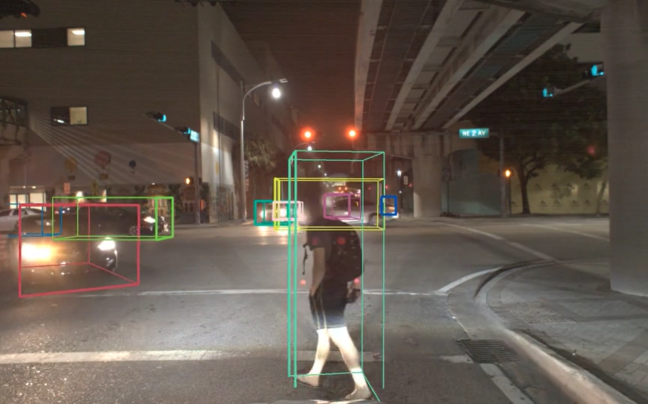

(Source: [Argoverse 1 Dataset](https://www.argoverse.org/av1.html))

- Another method could be using kinematic information of the car. The car know's its heading, velocity, and acceleration, allowing us to use the elapsed time to estimate our transform.
- Yet another method could be centroid of the point clouds. By computing translation between centroida and centroidb, we have half of a guess at the initial transform.

Ultimately, the cloud pairs that are being ICP-ed together are captured less than a second apart. It is possible then to just use the identity transform as the initial guess.

# Task 2: ICP Inner Components

The following consists of basic unit tests for individual components of ICP, for your debugging!

In [ ]:
class TestICPHelpers(unittest.TestCase):

    def setUp(self):
        self.testclouda = np.array([[1], [1], [1]])
        self.testcloudb = np.array([[2, 10], [1, 1], [1, 1]])
        self.testcloudc = np.array([[2], [1], [1]])
        self.testbTa = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(1, 0, 0))
        self.testcloude = np.array([[0, 20, 10], [0, 0, 0], [0, 0, 0]])
        self.testcloudf = np.array([[1, 21, 11], [0.5, 0.5, 0.5], [0, 0, 0]])

    def test_assign_closest_pairs1(self):
        expected = (3, 1)
        actual = assign_closest_pairs_naive(self.testclouda, self.testcloudb).shape
        self.assertEqual(expected, actual)

    def test_assign_closest_pairs2(self):
        expected = 2
        actual = assign_closest_pairs_naive(self.testclouda, self.testcloudb)[0][0]
        self.assertEqual(expected, actual)

    def test_icp1(self):
        ret = icp(self.testcloude, self.testcloudf)
        expected1 = type(gtsam.Pose3())
        actual1 = type(ret[0])
        self.assertEqual(expected1, actual1)
        expected2 = type([])
        actual2 = type(ret[1])
        self.assertEqual(expected2, actual2)
        expected3 = type([])
        actual3 = type(ret[1][0])
        self.assertEqual(expected3, actual3)

    def test_icp2(self):
        expected = 1
        actual = icp(self.testcloude, self.testcloudf)[0].x()
        self.assertEqual(expected, actual)

    def test_icp3(self):
        expected = 0.5
        actual = icp(self.testcloude, self.testcloudf)[0].y()
        self.assertEqual(expected, actual)

Step 2: Transform cloud

At this step, we transform the point cloud using the best transform estimate so far (or in the first iteration, the initial estimate). Luckily, you have already implemented an efficient way to transform clouds using `transform_cloud_numpy`, and you've seen how GTSAM can perform transforms with comparable speed. Feel free to use either `transform_cloud_numpy` or GTSAM to compute your transforms.

Step 3: Assign closest point pairs

#####**TODO 4**: Naive Assign Closest Pairs [5 pts]
Here is what you need to do:
- For each point in `clouda`, find the closest (based on the euclidean distance) point in `cloudb` and form a pair. 
- Return a cloud shaped like `clouda` that has been rearranged to give the closest point in `cloudb`. That is, in the returned array, the $i^{th}$ point is the point closest to `clouda[i]` in `cloudb`. This can be done with two for loops.


In [ ]:
def assign_closest_pairs_naive(clouda, cloudb):
    """Returns a rearranged version of cloudb,
    where index-wise corresponding points in
    clouda and rearranged cloudb are closest
    based on euclidean distance.

    Note: Don't modify clouda or cloudb here.

    Args:
        clouda (a numpy array of shape (3, n)): point cloud A
        cloudb (a numpy array of shape (3, m)): point cloud B

    Returns:
        a numpy array of shape (3, n), where each 3D point is a
        point from cloudb closest to the point at the same index
        in clouda
    """
    # TODO 4
    ############################################################################
    #                             START OF YOUR CODE                           #
    ############################################################################
    # print("클a", clouda)
    # print("클b", cloudb)
    # print(transform_cloud_numpy(clouda, cloudb))
    #cloud a 에있는 컬럼마다 cloudb에서 가장가까운것찾기..
    closest = [[],[],[]]
    for i in range(len(clouda[0])):
      point1 = np.array([clouda[0][i], clouda[1][i], clouda[2][i]])
      # print("point:",point1[0])
      minPoint  = [cloudb[0][0], cloudb[1][0], cloudb[2][0]]
        
      min_dist = np.linalg.norm(point1 - minPoint)
      for j in range(1, len(cloudb[0])):
        point2 = np.array([cloudb[0][j], cloudb[1][j], cloudb[2][j]])
        curr = np.linalg.norm(point1 - point2)
        if curr < min_dist:
          minPoint = point2
        # print("point b", point2)
      closest[0].append(minPoint[0])
      closest[1].append(minPoint[1])
      closest[2].append(minPoint[2])
    # print("리턴:", closest)
    return np.array(closest)
    # raise NotImplementedError("assign_closest_pairs_naive is not implemented")

    ############################################################################
    #                              END OF YOUR CODE                            #
    ############################################################################

In [ ]:
suite = unittest.TestSuite()
suite.addTest(TestICPHelpers('test_assign_closest_pairs1'))
suite.addTest(TestICPHelpers('test_assign_closest_pairs2'))
unittest.TextTestRunner().run(suite)

As you might have expected with the word "naive", there is a dire need to improve the performance of this method. Finding correspondences is the largest bottleneck in ICP, so one way to mitigate this is to use a more efficient algorithm such as KD Trees. The TAs have implemented the KD Tree version using sklearn, and the performance between the naive and KD Tree correspondence searches can be evaluated below.

In [ ]:
# Only every 200th point is used to reduce the necessary computation.
%timeit assign_closest_pairs_naive(clouda[:,::200], cloudb[:,::200])
%timeit helpers.assign_closest_pairs_KDTree(clouda[:,::200], cloudb[:,::200])

You should see that there is an enormous difference in speed between the brute force and KD Tree approach.  When implementing your own ICP algorithm, be sure to use the `assign_closest_pairs_KDTree` algorithm instead.

Step 4: Estimate transform

To perform this ICP step, use the `estimate_transform(clouda, cloudb)` function that is provided by the TAs. For the purposes of this project, you can use this function as a blackbox. Internally, this is calling `gtsam.Pose3.Align` which computes the best estimate to align two point clouds.

In [ ]:
help(helpers.estimate_transform)

Given clouda and cloudb, this function will return a `gtsam.Pose3` object (consisting of a rotational and translational component) that we can use to estimate a transform that aligns clouda with cloudb (i.e., minimizing the point-to point-distances from clouda to cloudb).

## Reflection Questions
1. Why does `assign_closest_pairs` return a "rearranged" cloud?

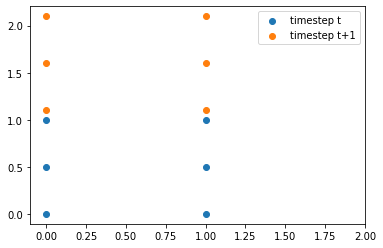

2. Observe the given example scans (2D clouds). What happens when you make correspondences based on shortest Euclidean distance like in `assign_closest_pairs`? Why might this be an issue?


# Task 3: Complete ICP Implementation

Step 5: Repeat steps 2-4 for maximum number of iterations or change is very small

#####**TODO 5:** Fully Implement ICP [15 pts]

Putting it all together. Using the four functions you've written, implement the complete ICP algorithm. Reminder that the five steps of ICP are:

1. Initial transform
2. Transform the `clouda` with `transform_cloud_numpy` to get `transformed_ cloud_a`.
3. Assign closest points between `transformed_ cloud_a` and `cloudb` with `helpers.assign_closest_pairs_KDTree`, which gives you a `rearranged_cloud_b`
4. Estimate the transform with `helpers.estimate_transform` using `clouda` and `rearranged_cloudb`.
5. Repeat steps 2-4 for max iterations or when change in the estimated transformation is below a threshold( lets say, a tolerance of 1e-2, `.equals()` method might be helpful here!)

Output expected:
- Your first output, `bTa`, is a gtsam.Pose3 object, which is the final transform describing how to transform clouda to align with cloudb. 
- The second output, `icp_series`, lets you visualize each iteration of your ICP algorithm. It is the list of transformed clouds obtained from after step 2 in each iteration along with cloudb. The format of `icp_series` is a list of lists. Example: `[[transformed_clouda_iter1, cloudb] [transformed_clouda_iter2, cloudb] , [transformed_clouda_iter3, cloudb], ...]`. Note that we are just using the original cloudb in each row, which will help use visualize later.

In [ ]:
def icp(clouda, cloudb, initial_transform=gtsam.Pose3(), max_iterations=25):
    """Runs ICP on two clouds by calling
    all five steps implemented above.
    Iterates until close enough or max
    iterations.

    Returns bTa, a gtsam.Pose3 object that aligns clouda with cloudb and a list of 
    intermediate transformations of clouda to cloudb (see above for formatting)
    for visualization purposes.

    Args:
        clouda (a numpy array of shape (3, n)): point cloud A
        cloudb (a numpy array of shape (3, n)): point cloud B
        initial_transform (gtsam.Pose3):        the initial estimate of transform 
                                                between  couda and cloudb (step 1 of icp)
        max_iterations (int):                   maximum iterations of ICP to run before breaking

    Returns:
        gtsam.Pose3, [series of clouds formatted for visualization]
    """
    bTa = gtsam.Pose3()
    icp_series = []

    # TODO 5
    ############################################################################
    #                             START OF YOUR CODE                           #
    ############################################################################
    # Initial transform
    # Transform the clouda with transform_cloud_numpy to get transformed_ cloud_a.
    # Assign closest points between transformed_ cloud_a and cloudb with helpers.assign_closest_points_KDTree, which gives you a rearranged_cloud_b
    # Estimate the transform with helpers.estimate_transform using clouda and rearranged_cloudb.
    # Repeat steps 2-4 for max iterations 
    #or when change in the estimated transformation is below a threshold( lets say, a tolerance of 1e-2, .equals() method might be helpful here!)
    # Output expected:

    # Your first output, bTa, is a gtsam.Pose3 object, which is the final transform describing how to transform clouda to align with cloudb.
    # The second output, icp_series, lets you visualize each iteration of your ICP algorithm. It is the list of transformed clouds obtained from after step 2 in
    #  each iteration along with cloudb. The format of icp_series is a list of lists. 
    #  Example: [[transformed_clouda_iter1, cloudb] [transformed_clouda_iter2, cloudb] , [transformed_clouda_iter3, cloudb], ...]. 
    #  Note that we are just using the original cloudb in each row, which will help use visualize later.
    # print("\nはじめます。\n")
    transform = initial_transform
    # print("clouda:\n", clouda)
    # print("\ncloudb:\n", cloudb)
    for i in range(max_iterations):
      #or when change in the estimated transformation is below a threshold( lets say, a tolerance of 1e-2, .equals() method might be helpful here!) 이러면하고말면안하고..
      if i > 0 and transform.equals(prev, tol = 0.01):
        # print("이쿼르",transform.equals(prev, tol = 0.01), "i", i, '\npre:\n',prev,'\ntrans:\n',transform)
        break
      # print("ㅋ\n",transform,'\n')
      #Transform the clouda with transform_cloud_numpy to get transformed_ cloud_a.
      transformed_clouda = transform_cloud_numpy(transform,clouda)
      icp_series.append([transformed_clouda, cloudb])
      # print("트클에",transformed_clouda)
      #Assign closest points between transformed_ cloud_a and cloudb with helpers.assign_closest_points_KDTree, which gives you a rearranged_cloud_b
      rearranged_cloudb = helpers.assign_closest_pairs_KDTree(transformed_clouda,cloudb)  #200씩 스킵하는건 하지않아야 3,3이나온다....
      # print("리클비\n", rearranged_cloudb)
      #Estimate the transform with helpers.estimate_transform using clouda and rearranged_cloudb.
      prev = transform
      transform = helpers.estimate_transform(clouda,rearranged_cloudb)
      
    bTa = transform
    # print("bTa\n", bTa )
    ############################################################################
    #                              END OF YOUR CODE                            #
    ############################################################################

    return bTa, icp_series

In [ ]:
suite = unittest.TestSuite()
suite.addTest(TestICPHelpers('test_icp1'))
suite.addTest(TestICPHelpers('test_icp2'))
suite.addTest(TestICPHelpers('test_icp3'))
unittest.TextTestRunner().run(suite)

Below is a simple test for ICP before running it on bigger point clouds.  
Each point cloud below contains points that represent a triangle in 3D space.  
Check if the points match before moving on. If your implementation is correct, you should see a transform that makes sense.

In [ ]:
# Load in two triangles
# Treat untranslated triangle as triangle a
triangle = np.array([[0.0, 0.0, 2.0],
                     [0.0, 1.0, 0.0],
                     [1.0, 1.0, 2.0]])
# Treat translated triangle as triangle b
triangle_translated = triangle + 1.0

# Use ICP to find the transform between them
aTb, _ = icp(triangle_translated, triangle)
print("\n------------- EXPECTED TRIANGLE ------------\n")
print(triangle)
print("\n------------- ACTUAL TRIANGLE --------------\n")
print(transform_cloud_numpy(aTb, triangle_translated))
print("\n------------- EXPECTED aTb -----------------\n")
print(gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(-1, -1, -1)))
print("\n------------- ACTUAL aTb -------------------\n")
print(aTb)

Now let's run ICP on the LIDAR data.  
The animation shows how clouda has moved after each iteration of ICP. You should see stationary landmarks, like walls and parked cars, converge onto each other.

In [ ]:
bTa, icp_series = icp(clouda, cloudb)
print(bTa)

driving.visualize_clouds([bTa.transformFrom(clouda), cloudb], show_grid_lines=True, cloud_colors=['#008B8B', '#FFA07A'])

Run the following cell if you'd like to see the ICP's iterative process of transforming clouda to align with cloudb.

In [ ]:
# icp_series_visualize = np.array([ [transformed_cloud_a, cloudb] for transformed_cloud_a in icp_series])
driving.visualize_clouds_animation(icp_series, speed=400, show_grid_lines=True, cloud_colors=['#008B8B', '#FFA07A'])

ICP is a computationally intense algorithm and we plan to run it between each cloud pair in our 180 clouds dataset. This can easily take over 2 hours if we don't optimize ICP here. Use the Python profiler to identify the computationally expensive subroutines in your algorithm. The TAs get ~8.4 seconds.

In [ ]:
%prun icp(clouda, cloudb)

## Reflection Questions

1. Why is the output of ICP denoted as `bTa` and not `aTb`? Refer to Section 6.1 in the textbook for transformation conventions.
2. Change the initial estimate for the ICP triangle example to be `gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(1, 1, 1))` and evaluate the result. Play around with changing the initial estimate. What happens when your initial estimate is initialized far away from the ground truth? Why is it important to have a good initial estimate?

# Using GTSAM for Pose Graph Optimization

Although you have already used GTSAM quite a few times already, you'll now be able to discover what a powerful optimization tool GTSAM can be (if you haven't already) by creating a factor graph for pose optimization in the next section.

First, let's get familiar with representing and visualizing 3D pose in GTSAM by running the following code block.

In [ ]:
# Translation is represented by a Point3 object (same as numpy array with 
# length 3). The 3 elements corresponds to x, y, z values.
translation = gtsam.Point3(1, 1, 2)

# Rotation is represented by Rot3 class. There are several ways to create a Rot3. 
# We create one by specifying the yaw, pitch, roll angles.
rotation = gtsam.Rot3.Ypr(np.pi/2, 0, 0)

# 3D pose is represeted by Pose3 class, which can be constructed with its 
# rotational (Rot3) and translational (Point3) components.
pose = gtsam.Pose3(rotation, translation)

# You can directly use print to show the pose. The rotation is shown as a 3x3 
# rotation matrix, and its translation is shown as a 3-vector.
print('pose:\n', pose)

# The uncertainty of the pose is represented its covariance matrix, which is of 
# shape 6x6. The upper-left 3x3 submatrix represents the covariance for rotation, 
# and the lower-right 3x3 submatrix represents the covariance for translation.
marginal = np.identity(6)
marginal[3, 3] = 5
marginal[4, 4] = 1
marginal[5, 5] = 0.5

# You can use the plot_pose3 function to visualize the pose with uncertaintites
# The x, y, z axes are represented with red, green, blue.
fig_num = 0
gtsam_plot.plot_pose3(fig_num, pose, axis_length=40, P=marginal);

The following code block shows factor graph optimization with a simple pose graph example. The factor graph includes 5 variables representing the poses of the robot at 5 time steps. There's a prior factor on the first variable, "between factor" (representing odometry measurement) connecting consecutive poses, and a loop closure factor.

An *odometry measurement* is a measure in the change of the robot's pose. For example, wheel encoders or Inertial Measurement Units are both sensors that can measure odometry. In our case with the Argo AI dataset, we are using point cloud registration as a form of odometry.

In [ ]:
# # Factor graph example 

################################################################################
########################## Create noise model ##################################
################################################################################
# Noise model represents the uncertainty for the measurements. In this example, 
# we directly specify uncertainty with standard deviation (sigma). The first 3 
# elements represent the sigmas of rotation; the last 3 elements represent the 
# sigmas of translation
prior_sigmas = np.array([0.1, 0.1, 0.1, 0.3, 0.3, 0.3])/20
between_sigmas = np.array([0.1, 0.1, 0.1, 0.2, 0.2, 0.2])/20
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(prior_sigmas)
between_noise = gtsam.noiseModel.Diagonal.Sigmas(between_sigmas)

################################################################################
######################## Create the factor graph ###############################
################################################################################
# - As you've learned that a factor graph consists of variable nodes and factor
# nodes. Recall that in GTSAM, a factor graph is a container of factors, and we 
# do not explicitly store variables in a factor graph. 
# - A variable is referred to by a unique "name" (an integer). We use 1, 2, 3,
# 4, 5 for the "names" of the 5 poses.
# - In this example, we will create a factor graph as follows:
#           5---•---4
#           |       |
#           •       •
#           |       |
#  •--1--•--2---•---3

# Create an empty factor graph. 
example_graph = gtsam.NonlinearFactorGraph()

# We first create a prior factor on the first pose (with name 1), with prior 
# value at the origin, and add it to the factor graph.
prior_factor = gtsam.PriorFactorPose3(1, gtsam.Pose3(), prior_noise)
example_graph.add(prior_factor)

# We then add "between factors" that represent odometry measurements to connect 
# consecutive pose variables. A between factor is specified by the name of the 
# first pose variable, the name of the second pose variable, and the relative 
# transform between the two poses.
# Notice that the noise model is required for all factors.
T_12 = gtsam.Pose3(gtsam.Rot3.Rz(0), gtsam.Point3(2, 0, 0))
T_23 = gtsam.Pose3(gtsam.Rot3.Rz(math.pi/2), gtsam.Point3(2, 0, 0))
T_34 = gtsam.Pose3(gtsam.Rot3.Rz(math.pi/2), gtsam.Point3(2, 0, 0))
T_45 = gtsam.Pose3(gtsam.Rot3.Rz(math.pi/2), gtsam.Point3(2, 0, 0))
example_graph.add(gtsam.BetweenFactorPose3(1, 2, T_12, between_noise)) 
example_graph.add(gtsam.BetweenFactorPose3(2, 3, T_23, between_noise)) 
example_graph.add(gtsam.BetweenFactorPose3(3, 4, T_34, between_noise)) 
example_graph.add(gtsam.BetweenFactorPose3(4, 5, T_45, between_noise)) 

# The loop closure factor is also represented as "between factor"
T_52 = gtsam.Pose3(gtsam.Rot3.Rz(math.pi/2), gtsam.Point3(2, 0, 0))
example_graph.add(gtsam.BetweenFactorPose3(5, 2, T_52, between_noise)) 

################################################################################
######################## Create initial guess ##################################
################################################################################
# - Initial values are necessary for nonlinear optimization
# - GTSAM uses "Values" type to store the values for variables. "Values" is like
# a dictionary object in Python, it maps the unique "name" of the variable to 
# its value
# - The initial values do not need to be very precise.

# Create empty Values object.
example_initial_estimate = gtsam.Values()

# Add initial estimates of poses to Values.
T_w1 = gtsam.Pose3(gtsam.Rot3.Rz(0.2), gtsam.Point3(0.5, 0.0, 0.0))
T_w2 = gtsam.Pose3(gtsam.Rot3.Rz(-0.2), gtsam.Point3(2.3, 0.0, 0.0))
T_w3 = gtsam.Pose3(gtsam.Rot3.Rz(math.pi/2), gtsam.Point3(4.1, 0.3, 0.0))
T_w4 = gtsam.Pose3(gtsam.Rot3.Rz(math.pi), gtsam.Point3(3.9, 2.2, 0.0))
T_w5 = gtsam.Pose3(gtsam.Rot3.Rz(-math.pi), gtsam.Point3(2.1, 2.1, 0.0))
example_initial_estimate.insert(1, T_w1)
example_initial_estimate.insert(2, T_w2)
example_initial_estimate.insert(3, T_w3)
example_initial_estimate.insert(4, T_w4)
example_initial_estimate.insert(5, T_w5)

################################################################################
################################# Optimize #####################################
################################################################################
# - Optimize the initial values using a Gauss-Newton nonlinear optimizer

# Set parameters for the optimizer.
opt_parameters = gtsam.GaussNewtonParams()
opt_parameters.setRelativeErrorTol(1e-5)
opt_parameters.setMaxIterations(100)

# Create the optimization problem with the factor graph and initial values.
ex_optimizer = gtsam.GaussNewtonOptimizer(example_graph, example_initial_estimate, opt_parameters)

# Solving the optimization problem returns the optimized values for variables.
ex_result = ex_optimizer.optimize()

################################################################################
############################### Visualization ##################################
################################################################################
# you can use print to show factor graphs and values
print("Factor Graph:\n", example_graph)
print("Final Result:\n", ex_result)

In [ ]:
# The uncertainties for each variable can be extracted by the "marginal" 
# probablity density of the variable.
marginals = gtsam.Marginals(example_graph, ex_result)

# Visualize the optimized poses with uncertainties.
fig = plt.figure(0, figsize=(8, 8), dpi=120)
ax = fig.gca(projection='3d')
for i in range(1, 6):
    gtsam_plot.plot_pose3(0, ex_result.atPose3(i), 0.5, marginals.marginalCovariance(i))

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

axisEqual3D(ax)
ax.view_init(azim=-90, elev=90)
plt.show()

With this refresher in GTSAM, you now know just enough to be dangerous in PoseSLAM ;)

## Reflection Questions

1. What information does a `gtsam.NonlinearFactorGraph()` hold compared to a `gtsam.Values()` object? What method do you use to access Pose3 values from a `gtsam.Values` object? 
2. Comment out the loop closure constraint and upload a screenshot of the covariance plot with and without loop closure. What does covariance represent? What happens to the covariance when loop closure is performed?

# Task 4: Pose Graph Optimization

In this section, we'll build a factor graph to estimate the pose of our vehicle using the transforms our ICP algorithm gives us between frames. These ICP transforms are the factors that tie the pose variables together.

We will be using GTSAM to construct the factor graph as well as perform a optimization for the pose of the car as it travels down the street. Recall from PoseSLAM describe in the LIDAR slides how we could add a factor (aka constraint) between two state variables. When we revisited a state, we could add a loop closure. Since the car in our dataset never revisits a previous pose, there is no loop closure.

These unit tests will verify the basic functionality of the function you've implemented in this section.

In [ ]:
import unittest

class TestFactorGraph(unittest.TestCase):

    def setUp(self):
        max_steps = 6
        test_clouds = helpers.read_ply(*scans_fnames)[:max_steps]
        PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))
        ICP_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))
        initial_pose = gtsam.Pose3(gtsam.Rot3(0.9982740, -0.0572837,  0.0129474, 0.0575611,  0.9980955, -0.0221840, -0.0116519,  0.0228910,  0.9996701),
                          gtsam.Point3(-263.9464864482589, 2467.3015467381383, -19.374652610889633))
        test_init_graph, test_initial_estimates = construct_graph_and_initial_estimates(initial_pose, test_clouds, PRIOR_NOISE, ICP_NOISE)
        self.max_steps = max_steps
        self.clouds = test_clouds
        self.icp_noise = ICP_NOISE
        self.init_graph = test_init_graph
        self.initial_estimates = test_initial_estimates

    def test_init_graph_params(self):
        self.assertTrue(type(self.init_graph) == gtsam.NonlinearFactorGraph)
        # 1 prior factor, 5 between factors connecting consecutive poses
        self.assertTrue(self.init_graph.size() == self.max_steps)

    def test_final_graph_params(self):
        test_final_graph = add_skip_connections(self.init_graph, self.clouds, self.icp_noise)
        self.assertTrue(type(test_final_graph) == gtsam.NonlinearFactorGraph)
        # 1 prior factor, 5 between factors connecting consecutive poses, 2 between
        # factors for skip connection
        self.assertTrue(test_final_graph.size() == self.max_steps + int((self.max_steps-1)/2))
    
    def test_initial_estimates_params(self):
        self.assertTrue(type(self.initial_estimates) == gtsam.Values)
        self.assertTrue(self.initial_estimates.size() == self.max_steps)
        for i in range(self.max_steps):
            self.assertTrue(self.initial_estimates.exists(i))

Before we start building our factor graph, we'll go through a small toy example to understand how composition works in GTSAM. ([Section 6.1.6](https://www.roboticsbook.org/S61_driving_state.html#composition-of-homogeneous-transformations)) 

In the following code block, we consider three frames (0, 1 and 2) and we define the transformations between (0 & 1) i.e T01 and (1 & 2) i.e T12. We show how we can use gtsam.Pose3.compose() to find T02 using T01 and T12. 

We apply this new (composed) transformation on a point and validate the result we get by doing the same process manually i.e, just multiplying the transformation matrices ourselves. 

This function will be useful when we start building our factor graph later.  

In [ ]:
## Toy example to understand gtsam.Pose3.compose()

# Create a transformation in SE(2)
# Here T01 is same as bTa convention that we've used up until now where a = 1 and b = 0
T01 =  gtsam.Pose2(1, 2, math.radians(0))
# Similarly for T12
T12 =  gtsam.Pose2(1, 2, math.radians(0))

# Point in 2nd coordinate frame
P2 = gtsam.Point2(4,3)

# Use gtsam.Pose3.compose() to find the transformation between frames 0 and 2 (Composition of T01 and T12)
gtsam_composition_T02 = T01.compose(T12)
manual_composition_T02 = T01*T12

# Pass the point through this new transformation
print(f"P0 = {gtsam_composition_T02.matrix() @ [4, 3, 1]}")  # need to make P2 homogeneous
print(f"P0 = {manual_composition_T02.matrix() @ [4, 3, 1]}")  # need to make P2 homogeneous
# Note that both of them gave us the same result
# The output tells us what P2 would look like when viewed from frame 0 (in homogeneous coordinates)

#####**TODO 6:** Construct PoseSLAM Factor Graph [15 pts]
You will be using your ICP implementation here to find the transform between two consecutive clouds. These transforms become the factors between pose variables in the graph. So, you will need to go through all the point clouds and run icp pair-wise to find the relative movement of the car. With these transformation, create a factor representing the transform between the pose variables.
1. Run ICP between consecutive clouds (hint: use the `initial_transform` argument). Note that ICP gives you a transformation that can take your points in clouda (first argument) frame to cloudb (second argument) frame. This intuition is very important for the next step. 
2. Compute the relative vehicle pose (hint: use `gtsam.Pose3.inverse()`). The relative vehicle pose is the transformation of cloudb frame with respect to clouda frame (not the points but the frame itself). Think about why the transformation that moves a point in frame A to a point in frame B and a transformation that moves a coordinate frame A to coordinate frame B are the exact same. That should tell you why and where `gtsam.Pose3.inverse()` would be useful. 
3. Add a `gtsam.BetweenFactorPose3()` object to the graph.
4. Obtain an initial estimate for the pose (hint: use `gtsam.Pose3.compose()`). Refer to the toy example above to understand how `gtsam.Pose3.compose()` works. 

In [ ]:
def construct_graph_and_initial_estimates(initial_pose, clouds, prior_noise, icp_noise):
    """Construct a factor graph and initial value estimates using transforms 
    generated from aligning point clouds with icp.

    Returns a graph (gtsam.NonlinearFactorGraph) with prior factor on the first 
    pose, and the between factors between pairs of clouds, along with our input 
    initial_estimates (gtsam.Values) of initial estimates for our vehicle pose 
    in world coordinates.

    Args:
        initial_pose (gtsam.Pose3):                the starting pose for the vehicle in world coordinates
        clouds (numpy array of shape (k, 3, n)):   the numpy array with all our point clouds
        prior_noise (gtsam.noiseModel):            noise representing uncertainty for prior factor
        icp_noise (gtsam.noiseModel):              noise representing uncertainty for between factors with icp
    
    Notes:
        - You can generate the prior factor with gtsam.PriorFactorPose3
        - You can generate relative pose constraint factors with gtsam.BetweenFactorPose3
        - You should use 0, 1, 2, 3 ... as the "names" for the variables representing poses of point clouds
        - For an input with 6 point clouds, your factor graph should contain 6 factors:
            prior factor on pose 0
            between factor on poses (0, 1)
            between factor on poses (1, 2)
            between factor on poses (2, 3)
            between factor on poses (3, 4)
            between factor on poses (4, 5)

    """
    graph = gtsam.NonlinearFactorGraph()
    initial_estimates = gtsam.Values()

    graph.add(gtsam.PriorFactorPose3(0, initial_pose, prior_noise))
    initial_estimates.insert(0, initial_pose)
    factor_pose = initial_pose

    # Add ICP Factors between each pair of clouds
    prev_T = gtsam.Pose3()
    for i in trange(len(clouds) - 1):

        # TODO 6
        ########################################################################
        #                           START OF YOUR CODE                         #
        ########################################################################
        
        #Run ICP between consecutive clouds (hint: use the initial_transform argument).
        #Note that ICP gives you a transformation that can take your points in clouda (first argument) frame to cloudb (second argument) frame.
        #This intuition is very important for the next step.
        bta, series = icp(clouds[i], clouds[i+1],prev_T)

        
        # Compute the relative vehicle pose (hint: use gtsam.Pose3.inverse()). 
        #The relative vehicle pose is the transformation of cloudb frame with respect to clouda frame (not the points but the frame itself). 
        #Think about why the transformation that moves a point in frame A to a point in frame B and a transformation that moves a coordinate frame A to 
        #coordinate frame B are the exact same.
        # That should tell you why and where gtsam.Pose3.inverse() would be useful.
        relative_vehicle_pose = gtsam.Pose3.inverse(bta);


        # Add a gtsam.BetweenFactorPose3() object to the graph.
        graph.add(gtsam.BetweenFactorPose3(i, i+1, relative_vehicle_pose,icp_noise ))
        # Obtain an initial estimate for the pose (hint: use gtsam.Pose3.compose()). Refer to the toy example above to understand how gtsam.Pose3.compose() works.
        next_level = factor_pose.compose(bta)
        initial_estimates.insert(i+1, next_level)
        prev_T= bta

        ########################################################################
        #                            END OF YOUR CODE                          #
        ########################################################################

    return graph, initial_estimates

In [ ]:
suite = unittest.TestSuite()
suite.addTest(TestFactorGraph('test_init_graph_params'))
suite.addTest(TestFactorGraph('test_initial_estimates_params'))
unittest.TextTestRunner().run(suite)

The real power of GTSAM will show here. In five lines, we'll setup a Gauss-Newton nonlinear optimizer and optimize for the vehicle's poses in world coordinates.

Note: This cell runs your ICP implementation 180 times. If you've implemented your ICP similarly to the TAs, expect this cell to take 2 minutes. If you're missing the `initial_transform` argument for icp, it may take ~1 hour.

In [ ]:
# Load in all clouds in our dataset.
clouds = helpers.read_ply(*scans_fnames)

# We get the initial pose of the car from Argo AI's dataset, and we add it to the graph as such.
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))
ICP_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))
initial_pose = gtsam.Pose3(gtsam.Rot3(0.9982740, -0.0572837,  0.0129474, 0.0575611,  0.9980955, -0.0221840, -0.0116519,  0.0228910,  0.9996701),
                           gtsam.Point3(-263.9464864482589, 2467.3015467381383, -19.374652610889633))

# We'll use your function to create the initial factor graph and initial estimates.
graph, initial_estimates = construct_graph_and_initial_estimates(initial_pose, clouds, PRIOR_NOISE, ICP_NOISE)

# Optimize for the states.
parameters = gtsam.GaussNewtonParams()
parameters.setRelativeErrorTol(1e-5)
parameters.setMaxIterations(100)
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimates, parameters)
result = optimizer.optimize()

Let's plot these poses to see how our vehicle moves.

Screenshot this for your reflection.

In [ ]:
poses_cloud = np.array([[], [], []])
for i in range(len(clouds)):
    poses_cloud = np.hstack([poses_cloud, np.array([[result.atPose3(i).x()], [result.atPose3(i).y()], [result.atPose3(i).z()]])])

init_car_pose = gtsam.Pose3(gtsam.Rot3(0.9982740, -0.0572837,  0.0129474, 0.0575611,  0.9980955, -0.0221840, -0.0116519,  0.0228910,  0.9996701),
                            gtsam.Point3(-263.9464864482589, 2467.3015467381383, -19.374652610889633))

driving.visualize_clouds([poses_cloud, transform_cloud_numpy(init_car_pose, clouds[0])], show_grid_lines=True, cloud_colors=['#ffa500', '#FFFFFF'])

## Reflection Questions
1. Upload a screenshot of your final vehicle trajectory.
2. What is the purpose of using `gtsam.Pose3.inverse()` in `construct_graph_and_initial_estimates`? What happens if we do not include this?
3. Suppose we have a robot that lives in 2D space and starts with an initial pose `gtsam.Pose2(0, 0, 0)`. The robot first performs the transform `gtsam.Pose2(1, 1, np.pi/2)` followed by a transform `gtsam.Pose2(-1, 1, np.pi/2)`. Both transformations are made relative to the **robot's respective body frames**.
  - Draw the robot's initial pose, second pose, and final pose on a 2D coordinate grid.
  - Calculate the robot's final pose using matrix multiplication. Show your work (with code or pen/paper).
  - Include a screenshot of calculating the robot's final pose using `gtsam.Pose2.compose()`. Does this make sense? Why?

# Task 5: Pose Graph Optimization with skip connections

We talked about how loop closure helps us consolidate conflicting data into a better global estimate. Unfortunately, our car does not perform loop closure. So, our graph would just be a long series of poses connected by icp-returned transforms. However, our LIDAR scans are noisy, which means that our icp-returned transforms are not perfect either. This ultimately results in incorrect vehicle poses and overall map.

One way that we can augment our graph is through "skip connections". We simply run ICP between every other cloud, and add these skip connections into the graph. You can basically perform ICP between two non-consecutive point clouds and add that transform as a factor in the factor graph.

#####**TODO 7:** Add Skip Connections [2 pts]

Add skip connections in between non-consecutive states of the factor graph.
1. Run ICP between non-consecutive clouds (hint: use initial_transform argument).
2. Compute the relative vehicle pose (hint: use `gtsam.Pose3.inverse()`).
3. Add a `gtsam.BetweenFactorPose3()` object to the graph.

In [ ]:
def add_skip_connections(graph, clouds, icp_noise):
    """Add skip connections between every non-consecutive state.

    Args:
        graph (gtsam.NonlinearFactorGraph):        the initial factor graph
        clouds (numpy array of shape (k, 3, n)):   the numpy array with all our point clouds
        icp_noise (gtsam.noiseModel):              noise representing uncertainty for between factors with icp
    Returns:
        graph (gtsam.NonlinearFactorGraph): factor graph with skip connections

    Note: If your factor graph has 6 variables like in the previous docstring, 
    adding skip connections should result in the following added constraints:
            between factor on poses (0, 2)
            between factor on poses (2, 4)
    """ 

    prev_T = gtsam.Pose3()
    for i in trange(0, len(clouds) - 2, 2):

        # TODO 7
        ########################################################################
        #                           START OF YOUR CODE                         #
        ########################################################################
        # Run ICP between non-consecutive clouds (hint: use initial_transform argument).
        bta, series = icp(clouds[i], clouds[i+2], prev_T)
        # Compute the relative vehicle pose (hint: use gtsam.Pose3.inverse()).
        relative_vehicle_pose = gtsam.Pose3.inverse(bta)

        # Add a gtsam.BetweenFactorPose3() object to the graph.
        graph.add(gtsam.BetweenFactorPose3(i,i+2,bta, icp_noise))

        prev_T = bta

        ########################################################################
        #                            END OF YOUR CODE                          #
        ########################################################################
    
    return graph

In [ ]:
suite = unittest.TestSuite()
suite.addTest(TestFactorGraph('test_final_graph_params'))
unittest.TextTestRunner().run(suite)

Now we'll setup a Gauss-Newton nonlinear optimizer and optimize for the vehicle's poses in world coordinates with skip connections

In [ ]:
# We'll now add the skip connections to your created factor graph.
graph = add_skip_connections(graph, clouds, ICP_NOISE)

# Optimize for the states.
parameters = gtsam.GaussNewtonParams()
parameters.setRelativeErrorTol(1e-5)
parameters.setMaxIterations(100)
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimates, parameters)
result = optimizer.optimize()

Let's plot these poses to see how our vehicle moves.

Screenshot this for your reflection. It would help if you observed a similar vehicle trajectory as before, but you'll quickly see why this is way better than what we had back without skip connections in the next section.

In [ ]:
poses_cloud = np.array([[], [], []])
for i in range(len(clouds)):
    poses_cloud = np.hstack([poses_cloud, np.array([[result.atPose3(i).x()], [result.atPose3(i).y()], [result.atPose3(i).z()]])])

driving.visualize_clouds([poses_cloud, transform_cloud_numpy(init_car_pose, clouds[0])], show_grid_lines=True, cloud_colors=['#ffa500', '#FFFFFF'])

## Reflection Questions
1. Upload a screenshot of your final vehicle trajectory with skip connections. If you didn't implement this, explain the expected trajectory with skip connections.
2. We have access to the first 60 ground-truth poses for the car with us (which you used earlier to visualize in **partial_result**, a gtsam.Values() object). Find the sum of squared differences between your pose graph output (with and without skip connections) and the ground-truth poses for the first 60 frames. Explain why you observe, what you observe (or expect to observe, if you didn't implement) in these two cases. 

# Mapping (revisited)

Now, we'll revisit the mapping function you created in the first section and finally complete the mapping component of PoseSLAM. The previous section used a factor graph to localize our vehicle's poses in world coordinates. We'll now use those poses to form a complete map of the street from the point clouds. If implemented correctly, the final map should be a large extension of the map seen in the first section.

Screenshot the result for your reflection.

In [ ]:
transforms = []
for i in range(len(clouds)):
    transforms.append(result.atPose3(i))

driving.visualize_clouds(transform_map(transforms, clouds), show_grid_lines=True, cloud_colors="#C6C6C6")

## Reflection Questions
1. Upload a screenshot of your final map.
2. Draw a factor graph between three point clouds, including skip connections.